In [ ]:
# Install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz

# Unzip the spark file to the current folder
!tar xf spark-3.1.1-bin-hadoop3.2.tgz

# Set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Install findspark using pip
!pip install -q findspark

# Spark for Python
!pip install pyspark==3.1.1

     |████████████████████████████████| 212.3 MB 14 kB/s 
     |████████████████████████████████| 198 kB 45.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767605 sha256=b489b60990d0548519124b74ec9f1a3dff5cd66f0161d1f4104411baec16a292
  Stored in directory: /root/.cache/pip/wheels/43/47/42/bc413c760cf9d3f7b46ab7cd6590e8c47ebfd19a7386cd4a57
Successfully built pyspark


In [ ]:
import findspark
findspark.init()
from pyspark.sql import Row, SparkSession
spark = SparkSession.builder.appName("ChicagoCrimeAnalysis").getOrCreate()

In [ ]:
## standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data  spark-3.1.1-bin-hadoop3.2  spark-3.1.1-bin-hadoop3.2.tgz


In [ ]:
# Data frame for input data
df = spark.read.csv('/content/drive/MyDrive/DS8003 Project/data/Crimes_-_2001_to_Present.csv', header=True, inferSchema=True)

# Caching this data frame as it's going to be read over and over again
df = df.cache()

df.show(10)
df.printSchema()

+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|      Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10224738|   HY411648|09/05/2015 01:30:...|     043XX S WOOD ST|0486|           BATTERY|DOMESTIC BATTERY ...|           RESIDENCE|

In [ ]:
df.describe().show()

+-------+-----------------+------------------+--------------------+--------------+------------------+-----------------+---------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+--------------------+--------------------+
|summary|               ID|       Case Number|                Date|         Block|              IUCR|     Primary Type|    Description|Location Description|              Beat|          District|              Ward|    Community Area|          FBI Code|      X Coordinate|      Y Coordinate|              Year|          Updated On|           Latitude|           Longitude|            Location|
+-------+-----------------+------------------+--------------------+--------------+------------------+-----------------+---------------+--------------------+------------------+------------------+------------------+---

In [ ]:
df.select('Block').distinct().count()

61750

In [ ]:
sel_columns = ['Block','IUCR','Primary Type','Location Description','District','Community Area','FBI Code','Year']

for c in sel_columns:
  print(f"Column: {c}, Unique Values Count: {df.select(c).distinct().count()}")

Column: Block, Unique Values Count: 61750
Column: IUCR, Unique Values Count: 402
Column: Primary Type, Unique Values Count: 36
Column: Location Description, Unique Values Count: 215
Column: District, Unique Values Count: 25
Column: Community Area, Unique Values Count: 79
Column: FBI Code, Unique Values Count: 26
Column: Year, Unique Values Count: 21


In [ ]:
crime_type_groups = df.groupBy('Primary Type').count()
crime_type_counts = crime_type_groups.orderBy('count', ascending=False)

In [ ]:
crime_type_counts.show(40)

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1557736|
|             BATTERY|1358033|
|     CRIMINAL DAMAGE| 844182|
|           NARCOTICS| 739132|
|             ASSAULT| 474218|
|       OTHER OFFENSE| 460362|
|            BURGLARY| 412103|
| MOTOR VEHICLE THEFT| 341249|
|  DECEPTIVE PRACTICE| 317637|
|             ROBBERY| 277799|
|   CRIMINAL TRESPASS| 207555|
|   WEAPONS VIOLATION|  92719|
|        PROSTITUTION|  69443|
|OFFENSE INVOLVING...|  52081|
|PUBLIC PEACE VIOL...|  51187|
|         SEX OFFENSE|  28576|
| CRIM SEXUAL ASSAULT|  27843|
|INTERFERENCE WITH...|  17721|
|            GAMBLING|  14602|
|LIQUOR LAW VIOLATION|  14563|
|               ARSON|  12536|
|            HOMICIDE|  11415|
|          KIDNAPPING|   7043|
|        INTIMIDATION|   4362|
|            STALKING|   4086|
|CRIMINAL SEXUAL A...|   3800|
|CONCEALED CARRY L...|    803|
|           OBSCENITY|    746|
|    PUBLIC INDECENCY|    187|
|       

[Text(0, 0.5, 'Primary Type'), Text(0.5, 0, 'Crimes Record Count')]

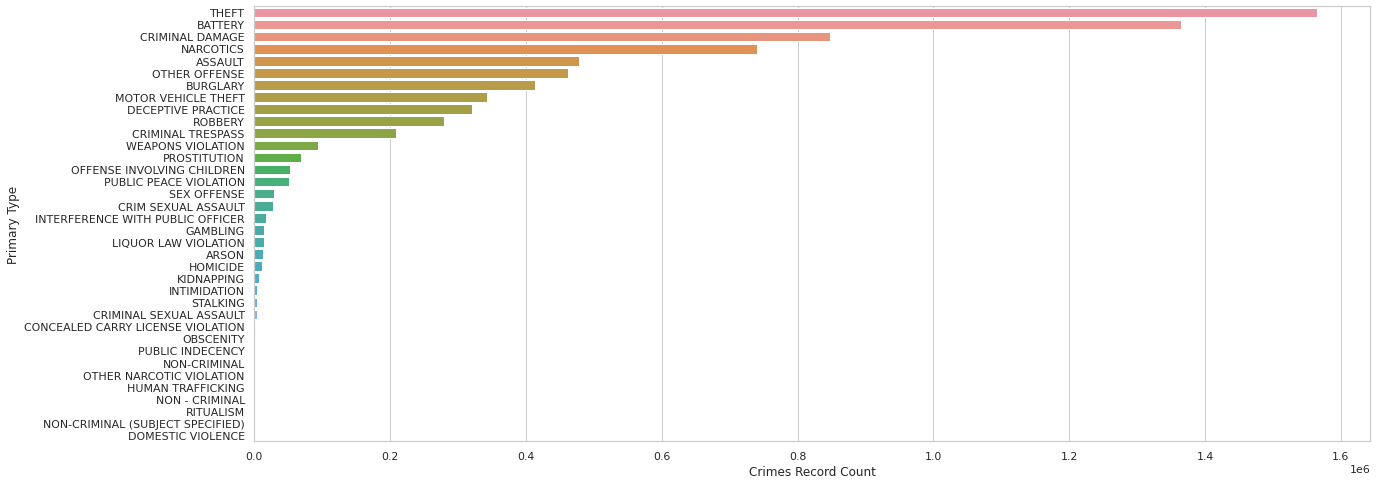

In [ ]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='Primary Type', data=crime_type_counts.toPandas())
type_graph.set(ylabel="Primary Type", xlabel="Crimes Record Count")

In [ ]:
df.select(min('date').alias('first_record_date'), max('date').alias('latest_record_date')).show(truncate=False)

+----------------------+----------------------+
|first_record_date     |latest_record_date    |
+----------------------+----------------------+
|01/01/2001 01:00:00 AM|12/31/2020 12:55:00 AM|
+----------------------+----------------------+



In [ ]:
# Adding a month column to be able to view stats on a monthly basis
df = df.withColumn('date_time', to_timestamp('date', 'MM/dd/yyyy hh:mm:ss a')).withColumn('month', trunc('date_time', 'YYYY'))

In [ ]:
df.select(['date','date_time', 'month']).show(n=2, truncate=False)

+----------------------+-------------------+----------+
|date                  |date_time          |month     |
+----------------------+-------------------+----------+
|09/05/2015 01:30:00 PM|2015-09-05 13:30:00|2015-01-01|
|09/04/2015 11:30:00 AM|2015-09-04 11:30:00|2015-01-01|
+----------------------+-------------------+----------+
only showing top 2 rows



In [ ]:
type_arrest_date = df.groupBy(['arrest', 'month']).count().orderBy(['month', 'count'], ascending=[True, False])
type_arrest_date.show(5)

+------+----------+------+
|arrest|     month| count|
+------+----------+------+
| false|2001-01-01|343894|
|  true|2001-01-01|141924|
| false|2002-01-01|345215|
|  true|2002-01-01|141561|
| false|2003-01-01|334387|
+------+----------+------+
only showing top 5 rows



In [ ]:
type_arrest_date_df = type_arrest_date.toPandas()

type_arrest_date_df['year_pd'] = type_arrest_date_df['month'].apply(lambda dt: datetime.datetime.strftime(pd.Timestamp(dt), '%Y'))
# type_arrest_date_df['arrest'] = type_arrest_date_df['arrest'].apply(lambda l: l=='true')

type_arrest_date_df.head()

,arrest,month,count,year_pd
0,False,2001-01-01,343894,2001
1,True,2001-01-01,141924,2001
2,False,2002-01-01,345215,2002
3,True,2002-01-01,141561,2002
4,False,2003-01-01,334387,2003


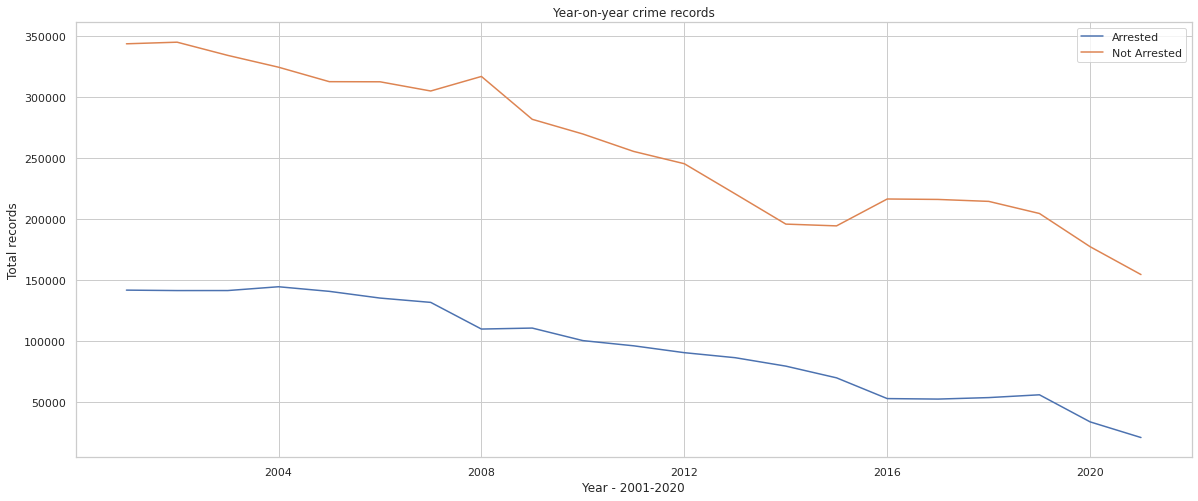

In [ ]:
# Data for plotting
t = type_arrest_date_df['count'] - 20 # np.arange(0.0, 2.0, 0.01)
s = type_arrest_date_df['month']

arrested = type_arrest_date_df[type_arrest_date_df['arrest'] == True]
not_arrested = type_arrest_date_df[type_arrest_date_df['arrest'] == False]

# Note that using plt.subplots below is equivalent to using
# fig = plt.figure() and then ax = fig.add_subplot(111)
fig, ax = plt.subplots()
ax.plot(arrested['month'], arrested['count'], label='Arrested')
ax.plot(not_arrested['month'], not_arrested['count'], label='Not Arrested')

ax.set(xlabel='Year - 2001-2020', ylabel='Total records',
       title='Year-on-year crime records')
ax.grid(b=True, which='both', axis='y')
ax.legend()

# It looks like the relative distance between arrests and non-arrests has remained constant..

In [ ]:
df_hour = df.withColumn('hour', hour(df['date_time']))

hourly_count = df_hour.groupBy(['Primary Type', 'hour']).count().cache()
hourly_total_count = hourly_count.groupBy('hour').sum('count')

hourly_count_df = pd.DataFrame(hourly_total_count.select(hourly_total_count['hour'], hourly_total_count['sum(count)'].alias('count')).rdd.map(lambda l: l.asDict()).collect())

hourly_count_df = hourly_count_df.sort_values(by='hour')

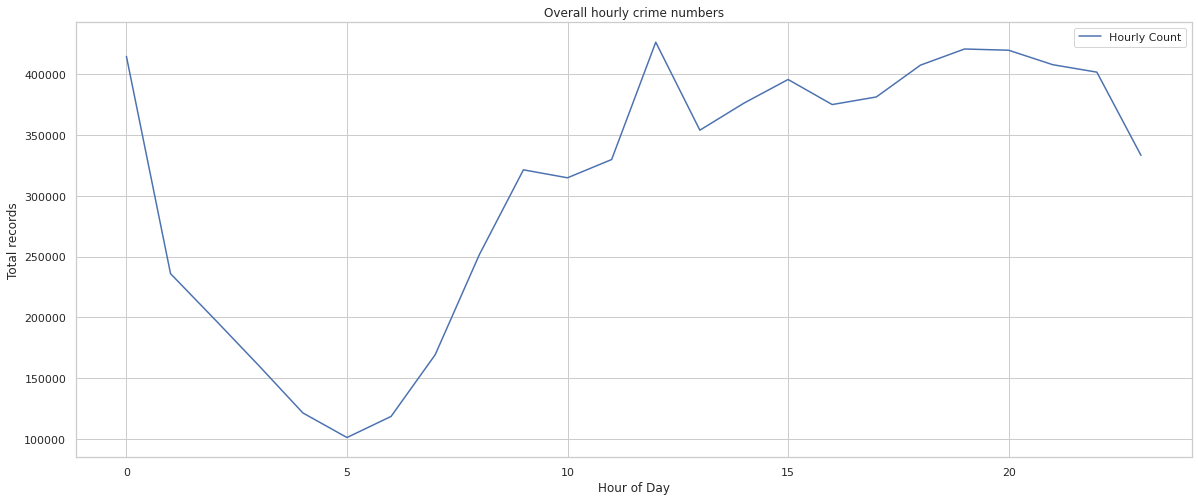

In [ ]:
fig, ax = plt.subplots()
ax.plot(hourly_count_df['hour'], hourly_count_df['count'], label='Hourly Count')

ax.set(xlabel='Hour of Day', ylabel='Total records',
       title='Overall hourly crime numbers')
ax.grid(b=True, which='both', axis='y')
ax.legend()

In [ ]:
df.select('Location Description').distinct().count()

215

In [ ]:
df_hour.groupBy(['Location Description']).count().orderBy('count', ascending=False).show(10)

+--------------------+-------+
|Location Description|  count|
+--------------------+-------+
|              STREET|1930065|
|           RESIDENCE|1260786|
|           APARTMENT| 812215|
|            SIDEWALK| 712054|
|               OTHER| 270069|
|PARKING LOT/GARAG...| 203014|
|               ALLEY| 165438|
|SCHOOL, PUBLIC, B...| 146393|
|  SMALL RETAIL STORE| 136881|
|    RESIDENCE-GARAGE| 135550|
+--------------------+-------+
only showing top 10 rows



In [ ]:
loc_desc_counts = df_hour.groupBy(['Location Description']).count().orderBy('count', ascending=False)
loc_desc_counts = loc_desc_counts.filter(loc_desc_counts['count'] >= 20000)

[Text(0, 0.5, 'Location Description'),
 Text(0.5, 0, 'Crimes Record Count (> 20000)')]

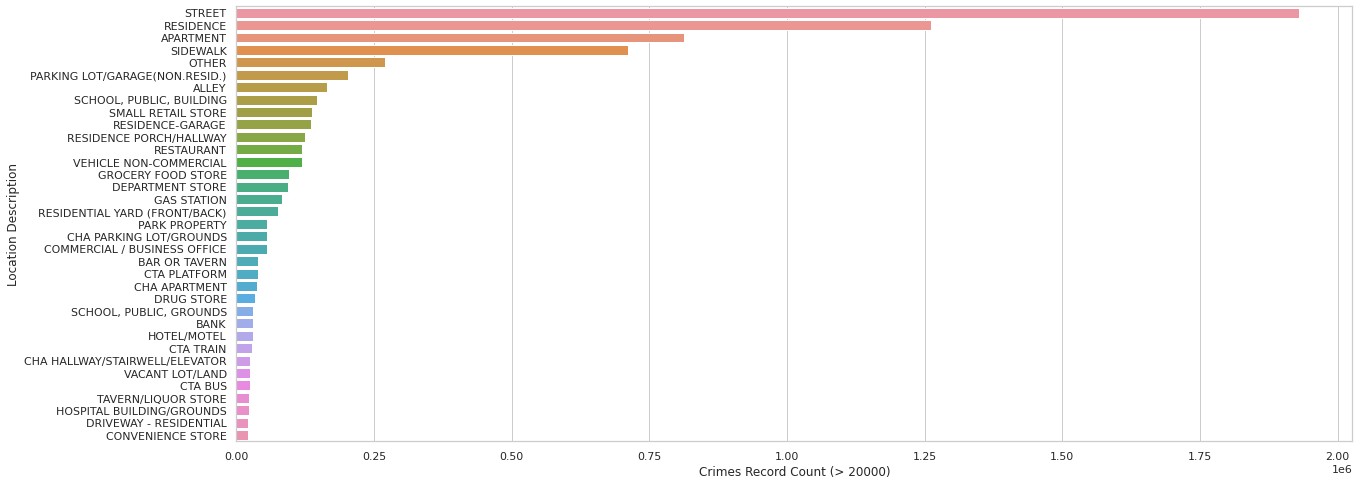

In [ ]:
plt.rcParams["figure.figsize"] = [20, 8]

sns.set(style="whitegrid")
sns.set_color_codes("pastel")

#sns.despine(left=True, bottom=True)
type_graph = sns.barplot(x='count', y='Location Description', data=loc_desc_counts.toPandas())
type_graph.set(ylabel="Location Description", xlabel="Crimes Record Count (> 20000)")

In [ ]:
location_hour = df_hour.groupBy(['Location Description', 'hour']).count().orderBy('hour')
location_hour.show(3)

+--------------------+----+-----+
|Location Description|hour|count|
+--------------------+----+-----+
|NURSING / RETIREM...|   0|   75|
|               HOTEL|   0|    2|
|       BAR OR TAVERN|   0| 5314|
+--------------------+----+-----+
only showing top 3 rows



In [ ]:
street_home_hour = location_hour.where((location_hour['Location Description'] == 'STREET') | (location_hour['Location Description'] == 'RESIDENCE'))

street_home_hour_df = street_home_hour.toPandas()
street_home_hour_df.head()

,Location Description,hour,count
0,STREET,0,121517
1,RESIDENCE,0,92966
2,STREET,1,74677
3,RESIDENCE,1,36122
4,RESIDENCE,2,30501


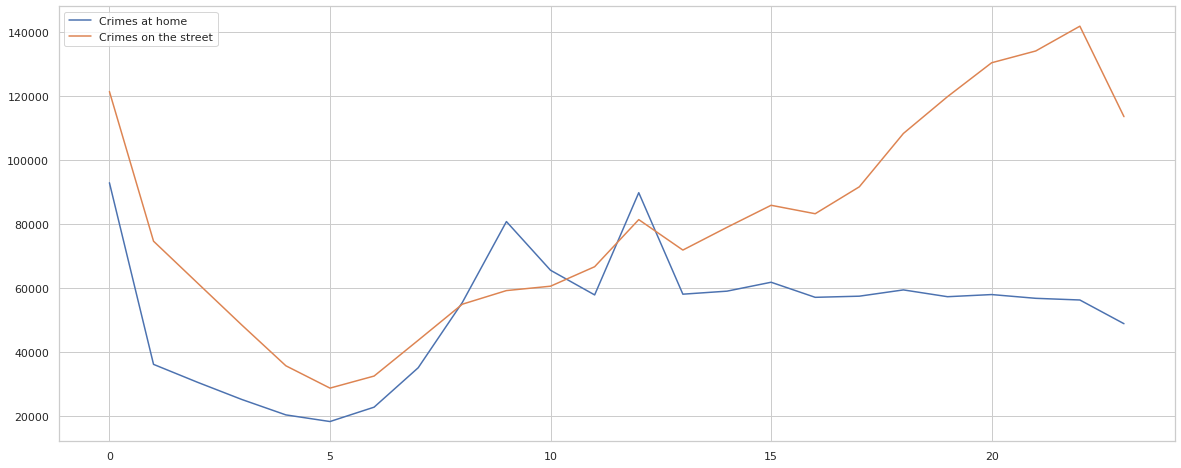

In [ ]:
figure, axes = plt.subplots()
axes.plot(street_home_hour_df[street_home_hour_df['Location Description'] == 'RESIDENCE']['hour'], 
          street_home_hour_df[street_home_hour_df['Location Description'] == 'RESIDENCE']['count'],
         label='Crimes at home')

axes.plot(street_home_hour_df[street_home_hour_df['Location Description'] == 'STREET']['hour'], 
          street_home_hour_df[street_home_hour_df['Location Description'] == 'STREET']['count'],
         label='Crimes on the street')

axes.legend()
ax.grid(b=True, which='both', axis='y')

In [ ]:
df_hour.head(1)

[Row(ID=10224738, Case Number='HY411648', Date='09/05/2015 01:30:00 PM', Block='043XX S WOOD ST', IUCR='0486', Primary Type='BATTERY', Description='DOMESTIC BATTERY SIMPLE', Location Description='RESIDENCE', Arrest=False, Domestic=True, Beat=924, District=9, Ward=12, Community Area=61, FBI Code='08B', X Coordinate=1165074, Y Coordinate=1875917, Year=2015, Updated On='02/10/2018 03:50:01 PM', Latitude=41.815117282, Longitude=-87.669999562, Location='(41.815117282, -87.669999562)', date_time=datetime.datetime(2015, 9, 5, 13, 30), month=datetime.date(2015, 1, 1), hour=13)]

In [ ]:
domestic_hour = pd.DataFrame(df_hour.groupBy(['Domestic', 'hour']).count().orderBy('hour').rdd.map(lambda row: row.asDict()).collect())
dom = domestic_hour[domestic_hour['Domestic'] == True]['count']
non_dom = domestic_hour[domestic_hour['Domestic'] == False]['count']

either_dom = domestic_hour.groupby(by=['hour']).sum()['count']

dom_keys = domestic_hour[domestic_hour['Domestic'] == False]['hour']

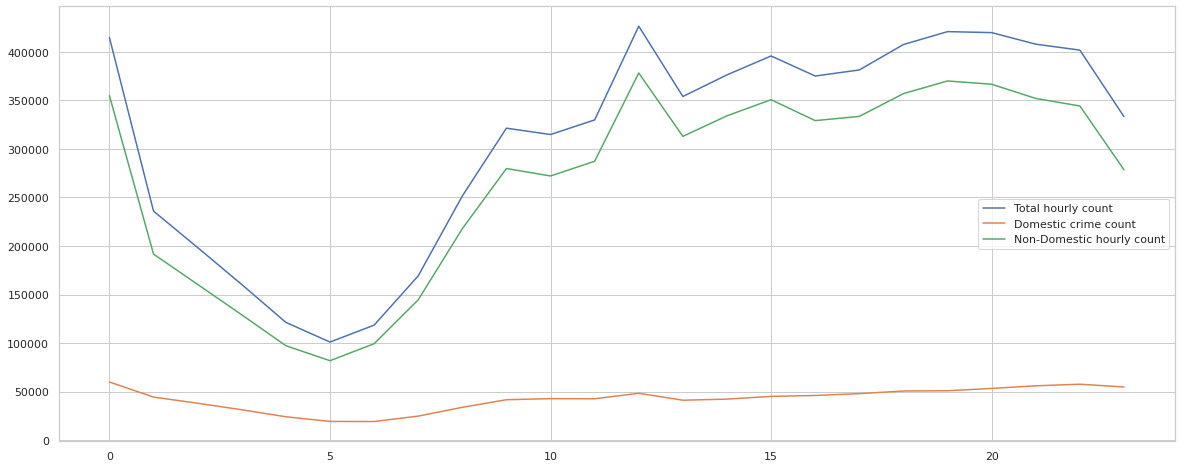

In [ ]:
# How do domestic crimes compare the other crimes?
figure, axes = plt.subplots()

axes.plot(dom_keys, either_dom, label='Total hourly count')
axes.plot(dom_keys, dom, label='Domestic crime count')
axes.plot(dom_keys, non_dom, label='Non-Domestic hourly count')

axes.legend()

In [ ]:
df_dates = df_hour.withColumn('week_day', dayofweek(df_hour['date_time']))\
                 .withColumn('year_month', month(df_hour['date_time']))\
                 .withColumn('month_day', dayofmonth(df_hour['date_time']))\
                 .withColumn('date_number', datediff(df['date_time'], to_date(lit('2001-01-01'), format='yyyy-MM-dd')))\
                 .cache()

In [ ]:
df_dates.select(['date', 'month', 'hour', 'week_day', 'year', 'year_month', 'month_day', 'date_number']).show(20, truncate=False)

+----------------------+----------+----+--------+----+----------+---------+-----------+
|date                  |month     |hour|week_day|year|year_month|month_day|date_number|
+----------------------+----------+----+--------+----+----------+---------+-----------+
|09/05/2015 01:30:00 PM|2015-01-01|13  |7       |2015|9         |5        |5360       |
|09/04/2015 11:30:00 AM|2015-01-01|11  |6       |2015|9         |4        |5359       |
|09/01/2018 12:01:00 AM|2018-01-01|0   |7       |2018|9         |1        |6452       |
|09/05/2015 12:45:00 PM|2015-01-01|12  |7       |2015|9         |5        |5360       |
|09/05/2015 01:00:00 PM|2015-01-01|13  |7       |2015|9         |5        |5360       |
|09/05/2015 10:55:00 AM|2015-01-01|10  |7       |2015|9         |5        |5360       |
|09/04/2015 06:00:00 PM|2015-01-01|18  |6       |2015|9         |4        |5359       |
|09/05/2015 01:00:00 PM|2015-01-01|13  |7       |2015|9         |5        |5360       |
|09/05/2015 11:30:00 AM|2015-01-

Day of week crime levels

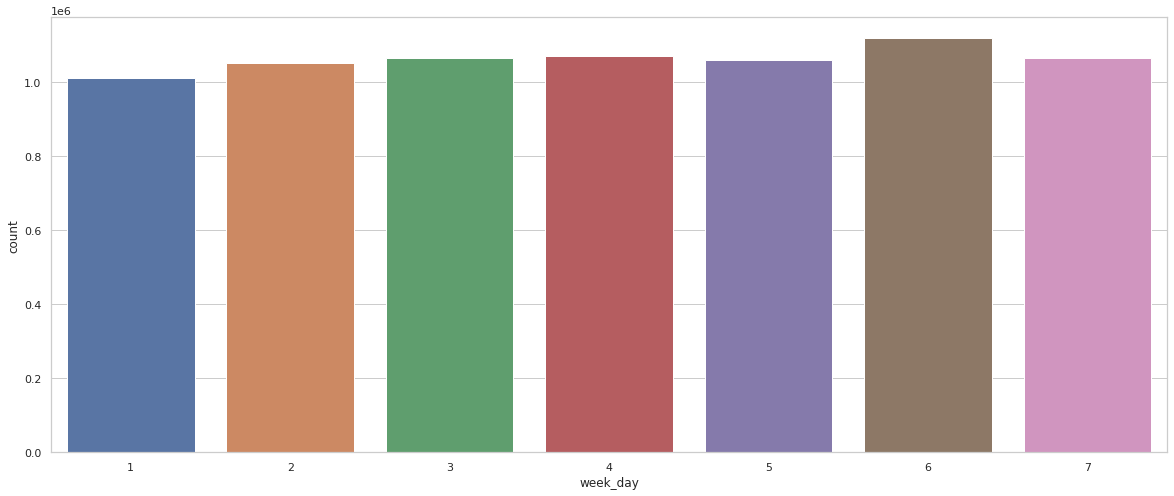

In [ ]:
week_day_crime_counts = df_dates.groupBy('week_day').count()

week_day_crime_counts_pddf = pd.DataFrame(week_day_crime_counts.orderBy('week_day').rdd.map(lambda e: e.asDict()).collect())

sns.barplot(data=week_day_crime_counts_pddf, x='week_day', y='count')

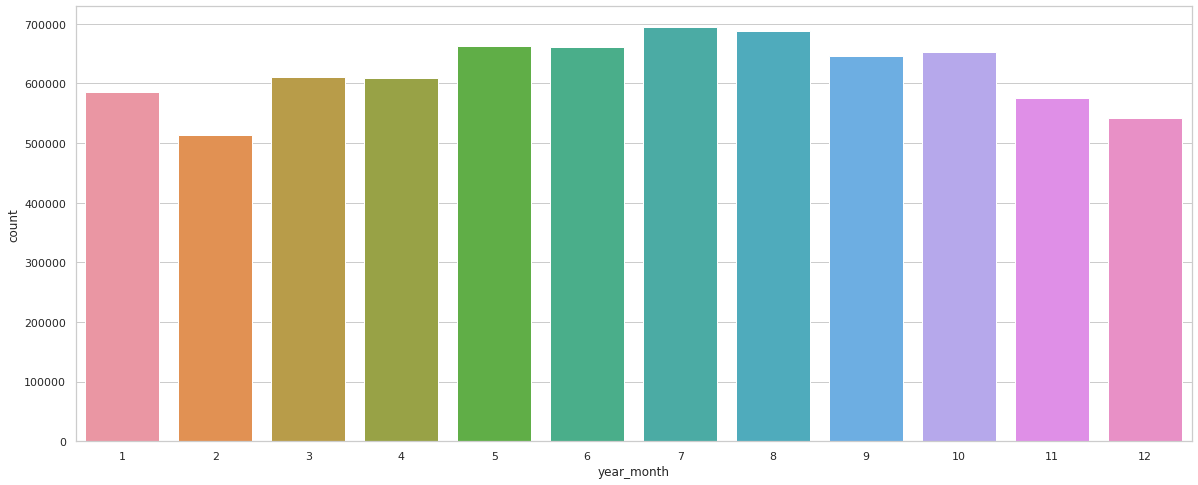

In [ ]:
year_month_crime_counts = df_dates.groupBy('year_month').count()

year_month_crime_counts_pddf = pd.DataFrame(year_month_crime_counts.orderBy('year_month').rdd.map(lambda e: e.asDict()).collect())

sns.barplot(data=year_month_crime_counts_pddf, y='count', x='year_month')

In [ ]:
month_day_crime_counts = df_dates.groupBy('month_day').count()

month_day_crime_counts_pddf = pd.DataFrame(month_day_crime_counts.orderBy('month_day').rdd.map(lambda e: e.asDict()).collect())

In [ ]:
# Top 10 worst days of the month
month_day_crime_counts_pddf.sort_values(by='count', ascending=False).head(10)

,month_day,count
0,1,293839
14,15,252201
19,20,248139
9,10,245956
16,17,244771
13,14,244337
15,16,244009
11,12,243213
4,5,243066
20,21,242948


In [ ]:
month_day_crime_counts_pddf = month_day_crime_counts_pddf.sort_values(by='month_day', ascending=True)

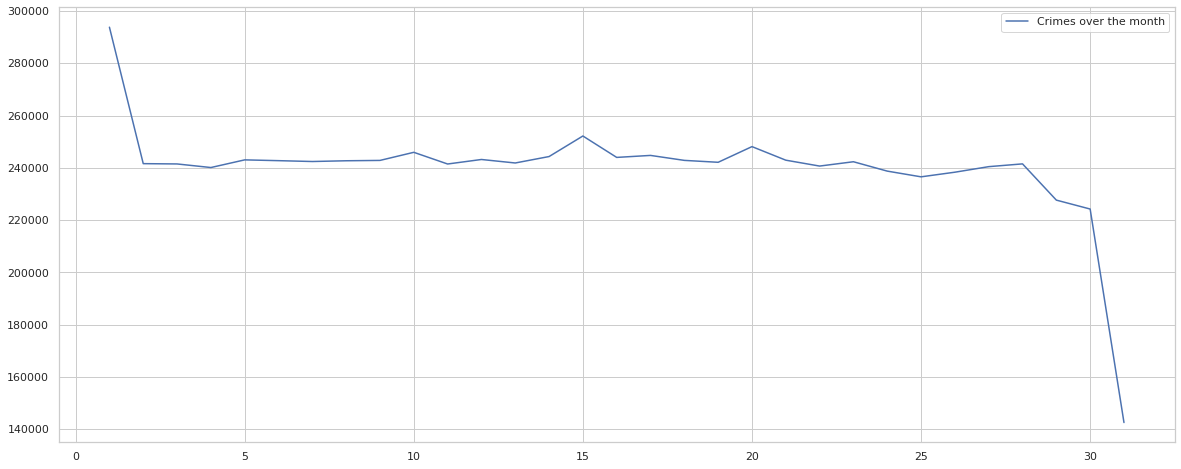

In [ ]:
fg, ax = plt.subplots()

ax.plot(month_day_crime_counts_pddf['month_day'], month_day_crime_counts_pddf['count'], label='Crimes over the month')

ax.grid(b=True, which='both')
ax.legend()

In [ ]:
# Community areas
df_dates_community_areas = df_dates.na.drop(subset=['Community Area']).groupBy('Community Area').count()

# Top 10 worst community areas
df_dates_community_areas.orderBy('count', ascending=False).show(10)

+--------------+------+
|Community Area| count|
+--------------+------+
|            25|430585|
|             8|237574|
|            43|224357|
|            23|214928|
|            28|203395|
|            29|199911|
|            24|199807|
|            67|198309|
|            71|193924|
|            49|182083|
+--------------+------+
only showing top 10 rows



In [ ]:
## Is it possible to see how the top crime types occur in the top crime-affected areas?
top_crime_types = df_dates.select('Primary Type').groupBy('Primary Type').count().rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])
top_busy_areas =  df_dates_community_areas.rdd.map(lambda row: row.asDict()).takeOrdered(10, key=lambda l: 1/l['count'])

In [ ]:
top_crime_types_lst = [dc['Primary Type'] for dc in top_crime_types]
top_busy_areas_lst = [dc['Community Area'] for dc in top_busy_areas]

In [ ]:
top_crime_types_lst

['THEFT',
 'BATTERY',
 'CRIMINAL DAMAGE',
 'NARCOTICS',
 'ASSAULT',
 'OTHER OFFENSE',
 'BURGLARY',
 'MOTOR VEHICLE THEFT',
 'DECEPTIVE PRACTICE',
 'ROBBERY']

In [ ]:
top_busy_areas_lst

[25, 8, 43, 23, 28, 29, 24, 67, 71, 49]

In [ ]:
top_busy_areas_lst = [str(b) for b in top_busy_areas_lst]

In [ ]:
q1 = "instr('" + ' '.join(top_busy_areas_lst) + "', community_area) > 0"
q2 = "instr('" + ' '.join(top_crime_types_lst) + "', primary_type) > 0"

In [ ]:
df_dates = df_dates.withColumnRenamed('Community Area', 'community_area')
df_dates = df_dates.withColumnRenamed('Primary Type', 'primary_type')
df_dates = df_dates.withColumn('community_area', col('community_area').cast('string'))

df_dates.show(5)

+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+-------------------+----------+----+--------+----------+---------+-----------+
|      ID|Case Number|                Date|               Block|IUCR|primary_type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|community_area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|          date_time|     month|hour|week_day|year_month|month_day|date_number|
+--------+-----------+--------------------+--------------------+----+------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------

In [ ]:
## Construct a data frame filtered on these top community areas and top crime types:
df_dates_tops = df_dates.filter(q1).filter(q2)
df_dates_tops.count()


2671719

In [ ]:
tops_of_tops = df_dates_tops.groupBy(['primary_type', 'community_area']).count().orderBy(['primary_type', 'count', 'community_area'], ascending=[True, False, True]).cache()

tops_of_tops.show(20)

+------------+--------------+-----+
|primary_type|community_area|count|
+------------+--------------+-----+
|     ASSAULT|            25|27122|
|     ASSAULT|            43|16850|
|     ASSAULT|            67|15341|
|     ASSAULT|            71|14580|
|     ASSAULT|            49|14450|
|     ASSAULT|            23|13900|
|     ASSAULT|            29|13072|
|     ASSAULT|            28|11612|
|     ASSAULT|            24| 9918|
|     ASSAULT|             8| 9167|
|     ASSAULT|             1| 6345|
|     ASSAULT|             3| 6328|
|     ASSAULT|             6| 4836|
|     ASSAULT|             2| 4803|
|     ASSAULT|             7| 3021|
|     ASSAULT|             4| 2474|
|     ASSAULT|             5| 1690|
|     ASSAULT|             9|  372|
|     BATTERY|            25|87082|
|     BATTERY|            43|49581|
+------------+--------------+-----+
only showing top 20 rows



In [ ]:
area_names = """
01	Rogers Park	
40	Washington Park
02	West Ridge	
41	Hyde Park
03	Uptown	
42	Woodlawn
04	Lincoln Square	
43	South Shore
05	North Center	
44	Chatham
06	Lakeview	
45	Avalon Park
07	Lincoln Park	
46	South Chicago
08	Near North Side	
47	Burnside
09	Edison Park	
48	Calumet Heights
10	Norwood Park	
49	Roseland
11	Jefferson Park	
50	Pullman
12	Forest Glen	
51	South Deering
13	North Park	
52	East Side
14	Albany Park	
53	West Pullman
15	Portage Park	
54	Riverdale
16	Irving Park	
55	Hegewisch
17	Dunning	
56	Garfield Ridge
18	Montclare	
57	Archer Heights
19	Belmont Cragin	
58	Brighton Park
20	Hermosa	
59	McKinley Park
21	Avondale	
60	Bridgeport
22	Logan Square	
61	New City
23	Humboldt Park	
62	West Elsdon
24	West Town	
63	Gage Park
25	Austin	
64	Clearing
26	West Garfield Park 	
65	West Lawn
27	East Garfield Park	
66	Chicago Lawn
28	Near West Side	
67	West Englewood
29	North Lawndale	
68	Englewood
30	South Lawndale	
69	Greater Grand Crossing
31	Lower West Side	
70	Ashburn
32	Loop	
71	Auburn Gresham	
33	Near South Side	
72	Beverly
34	Armour Square	
73	Washington Heights
35	Douglas	
74	Mount Greenwood
36	Oakland	
75	Morgan Park
37	Fuller Park	
76	O'Hare
38	Grand Boulevard	
77	Edgewater
39	Kenwood	
"""

In [ ]:
code_pairs = [[float(p[0]), p[1]] for p in [pair.strip().split('\t') for pair in area_names.strip().split('\n')]]
code_pairs[:5]


[[1.0, 'Rogers Park'],
 [40.0, 'Washington Park'],
 [2.0, 'West Ridge'],
 [41.0, 'Hyde Park'],
 [3.0, 'Uptown']]

In [ ]:
community_area_counts = df_dates_community_areas.toPandas()

In [ ]:
# Create a dictionary of area code to names
area_name_dic = {float(k[0]):k[1] for k in code_pairs}

In [ ]:
community_area_counts['community_area_name'] = community_area_counts['Community Area'].apply(lambda area: area_name_dic.get(float(area),  'unknown_%s'%area))
community_area_counts = community_area_counts.sort_values(by='count')
community_area_counts.head(5)

,Community Area,count,community_area_name
74,0,76,unknown_0
32,9,6704,Edison Park
11,47,10240,Burnside
9,12,12483,Forest Glen
37,55,14951,Hegewisch


[Text(0, 0.5, 'Community Area Name'),
 Text(0.5, 0, 'Overall Crimes Record Count')]

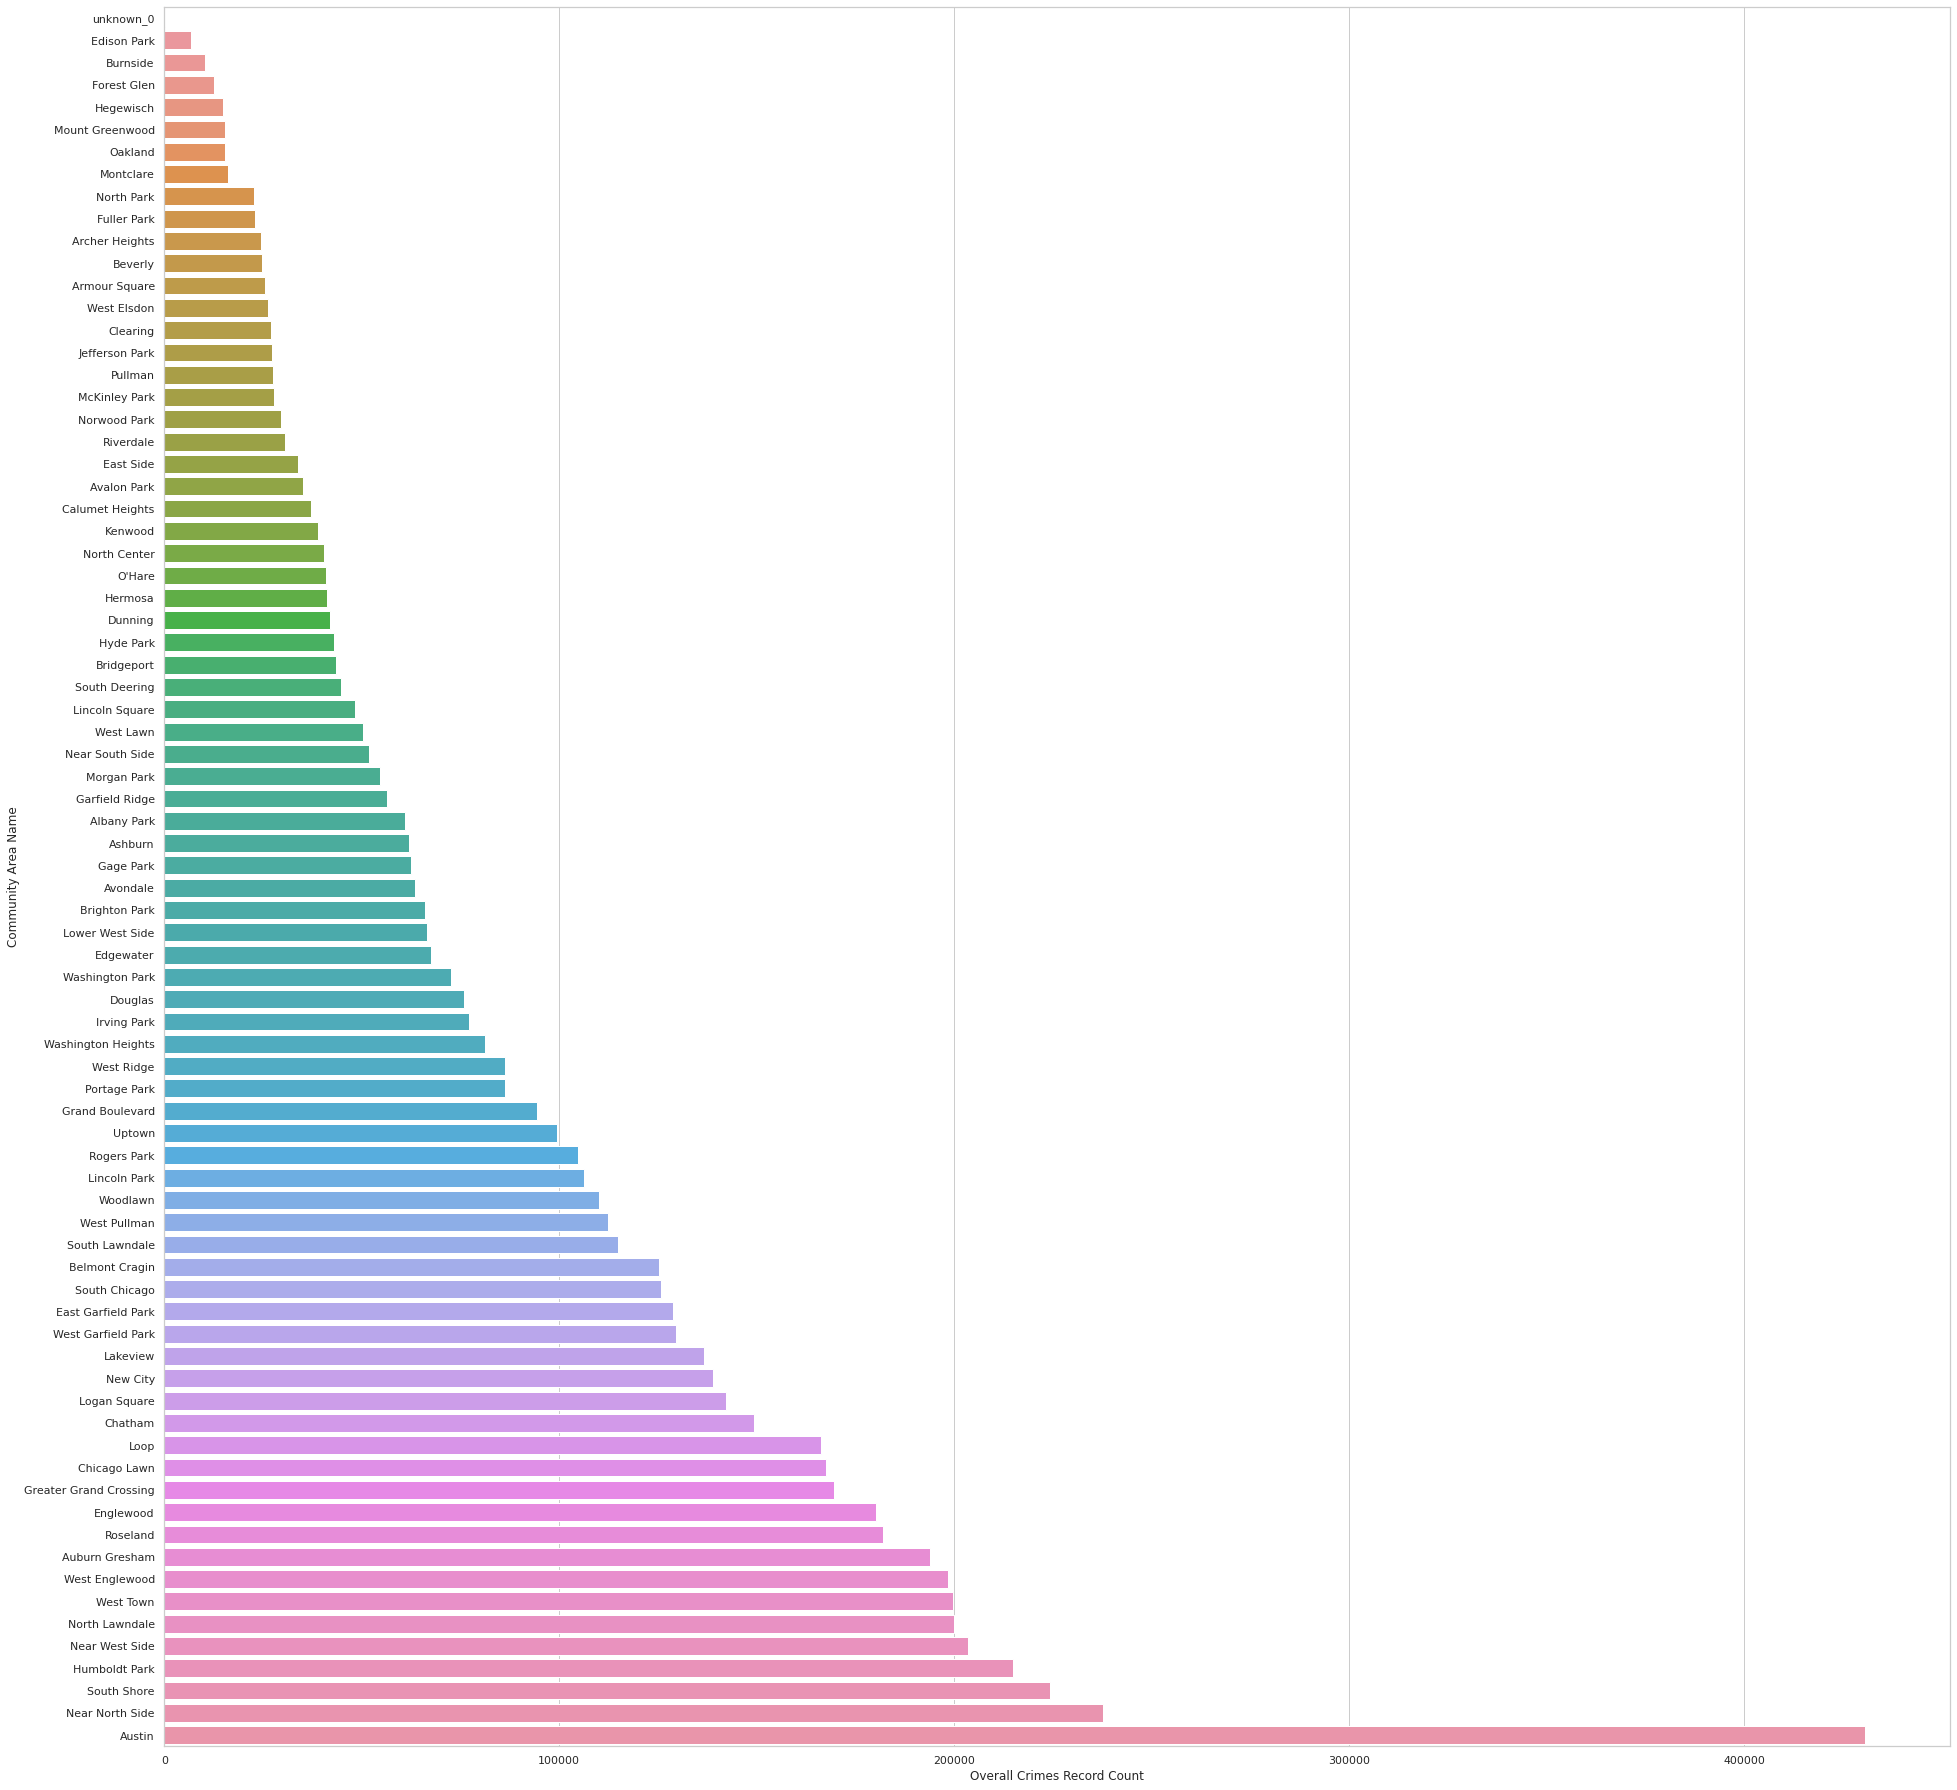

In [ ]:
# What is happening in Austin?

plt.rcParams["figure.figsize"] = [32, 32]

sns.set(style="whitegrid") 
sns.set_color_codes("pastel")
sns.despine(left=True, bottom=True)
area_chart = sns.barplot(x='count', y='community_area_name', data=community_area_counts) 
area_chart.set(ylabel="Community Area Name", xlabel="Overall Crimes Record Count")

In [ ]:
code_pairs_df = spark.createDataFrame(code_pairs, ['community_area', 'area_name'])
named_tops_of_tops = code_pairs_df.join(tops_of_tops, on='community_area', how='right')
named_tops_of_tops.show(10)

+--------------+---------------+-------------------+-----+
|community_area|      area_name|       primary_type|count|
+--------------+---------------+-------------------+-----+
|             8|Near North Side|            ASSAULT| 9167|
|             8|Near North Side|            BATTERY|30829|
|             8|Near North Side|           BURGLARY| 5603|
|             8|Near North Side|    CRIMINAL DAMAGE|14984|
|             8|Near North Side| DECEPTIVE PRACTICE|24310|
|             8|Near North Side|MOTOR VEHICLE THEFT| 5459|
|             8|Near North Side|          NARCOTICS|10332|
|             8|Near North Side|      OTHER OFFENSE| 8438|
|             8|Near North Side|            ROBBERY| 6232|
|             8|Near North Side|              THEFT|98402|
+--------------+---------------+-------------------+-----+
only showing top 10 rows



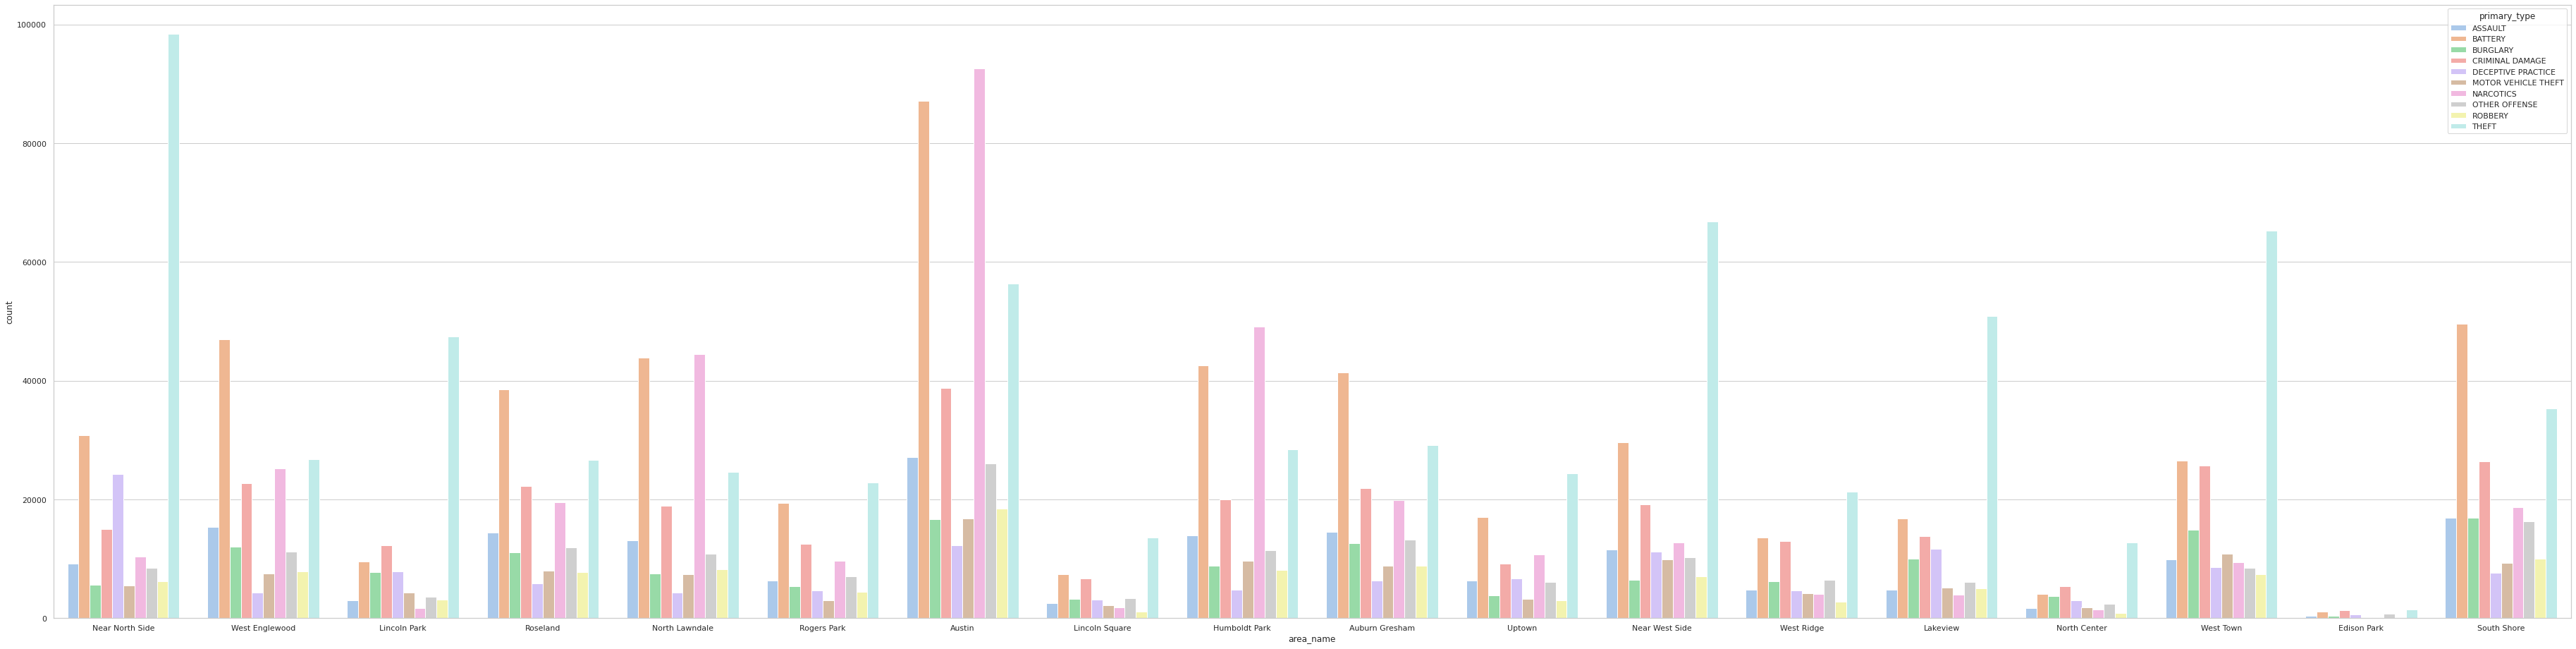

In [ ]:
tops_of_tops_dff = pd.DataFrame(named_tops_of_tops.rdd.map(lambda l: l.asDict()).collect() )
plt.rcParams["figure.figsize"] = [64, 16]
sns.barplot(data=tops_of_tops_dff, x='area_name', y='count', hue='primary_type', palette='pastel')